<a href="https://colab.research.google.com/github/Pacoanes/State-of-the-art/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import sys
sys.path.append("..")
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras import layers as L
import tarfile

Using TensorFlow backend.


In [0]:
def detect_faces(cascade, test_image):
    image_copy = test_image.copy()
    faces_rect = cascade.detectMultiScale(image_copy, minSize=(50, 50), scaleFactor=1.1, minNeighbors=10)
    
    if (faces_rect==()): # si no reconoce cara
        return 0
      
    else:
        for (x, y, w, h) in faces_rect:
            r = max(w, h) / 1.17
            centerx = x + w / 2
            centery = y + h / 2
            nx = int(centerx - r)
            ny = int(centery - r)
            nr = int(r * 2)
    faceimg = image_copy[ny:ny+nr+10, nx:nx+nr+10]

    return faceimg

In [0]:
cascade_face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17969430981873332597, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15601766547503492185
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11319353549858950544
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11326753997
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6981116704775517022
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [6]:
drive.mount("/content/drive", force_remount=True)
path = "/content/drive/My Drive/ban/raw1"
training_data = []
for img in os.listdir(path):  
    try:
        img_array = cv2.imread(os.path.join(path,img))  
        faces = detect_faces(cascade_face, img_array)
        img_rgb = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_rgb, (200, 200))
        training_data.append(new_array)
    except Exception as e:  
        pass
print(len(training_data))

Mounted at /content/drive


KeyboardInterrupt: ignored

In [0]:
def take_images():
    res = []
    with tarfile.open('raw.tgz') as f:
        for m in tqdm.tqdm(f.getmembers()):
            try:
                img = cv2.imdecode(np.asarray(bytearray(f.extractfile(m).read()), dtype=np.uint8), 1)  
                faces = detect_faces(cascade_face, img)
                img_rgb = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_rgb, (200, 200))
                res.append(new_array)
            except:  
                pass
    print(" {} images".format(len(res)))
    return res

In [8]:
training_dat =take_images()
training_dat = np.float32(training_dat)/255.

  0%|          | 0/4714 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """
100%|██████████| 4714/4714 [01:57<00:00, 49.88it/s]


 1364 images


In [9]:
IMG_SHAPE_ban=training_dat.shape[1:]
IMG_SHAPE_ban

(200, 200, 3)

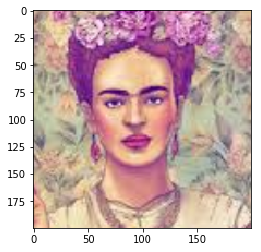

In [10]:
plt.imshow(training_dat[np.random.randint(training_dat.shape[0])], cmap="gray", interpolation="none")

In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [12]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
tf.test.gpu_device_name()
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=1)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [30]:
#red generadora
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(128*24*24, activation='elu'))
generator.add(L.Reshape((24,24,128)))
generator.add(L.Deconv2D(128,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(6,6)))
generator.add(L.Deconv2D(64,kernel_size=4,activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=4,activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=4,activation='elu'))
generator.add(L.Conv2D(3,kernel_size=2,activation=None))
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 73728)             18948096  
_________________________________________________________________
reshape_3 (Reshape)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 128)       409728    
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 32, 32, 64)        204864    
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 192, 192, 64)      0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 195, 195, 64)      65600     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 198, 198, 64)      65600     
__________

In [31]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE_ban))

discriminator.add(L.Conv2D(8, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.Conv2D(16, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))

discriminator.add(L.Conv2D(32, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.Conv2D(64, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))


# <build discriminator body>

discriminator.add(L.Flatten())
discriminator.add(L.Dense(128,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 198, 198, 8)       224       
_________________________________________________________________
batch_normalization_9 (Batch (None, 198, 198, 8)       32        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 198, 198, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 196, 196, 16)      1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 196, 196, 16)      64        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 196, 196, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 98, 98, 16)        0         
__________

In [0]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE_ban))

logp_real = discriminator(real_data)

generated_data = generator(noise) #<gen(noise)>

logp_gen = discriminator(generated_data) #<log P(real | gen(noise))




In [0]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
 
disc_optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [0]:
########################
###generator training###
########################

g_loss = tf.reduce_mean(logp_gen[:,0]) # <generator loss>

gen_optimizer =tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)
    

In [0]:
s.run(tf.global_variables_initializer())

In [0]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(training_dat.shape[0]), size=bsize)
    return training_dat[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(training_dat),np.max(training_dat))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE_ban),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE_ban),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()



  0%|          | 0/50000 [00:00<?, ?it/s]

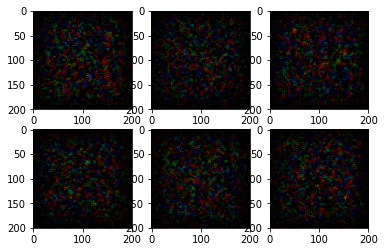



  0%|          | 1/50000 [00:18<254:52:28, 18.35s/it]

  0%|          | 2/50000 [00:30<230:21:04, 16.59s/it]

  0%|          | 3/50000 [00:43<213:06:50, 15.35s/it]

  0%|          | 4/50000 [00:55<201:04:11, 14.48s/it]

  0%|          | 5/50000 [01:08<192:33:44, 13.87s/it]

  0%|          | 6/50000 [01:20<186:38:23, 13.44s/it]

  0%|          | 7/50000 [01:33<182:35:47, 13.15s/it]

  0%|          | 8/50000 [01:45<179:42:04, 12.94s/it]

  0%|          | 9/50000 [01:57<177:33:17, 12.79s/it]

  0%|          | 10/50000 [02:10<176:09:15, 12.69s/it]

  0%|          | 11/50000 [02:22<175:22:32, 12.63s/it]

  0%|          | 12/50000 [02:35<174:40:33, 12.58s/it]

  0%|          | 13/50000 [02:47<174:06:50, 12.54s/it]

  0%|          | 14/50000 [03:00<173:41:05, 12.51s/it]

  0%|          | 15/50000 [03:12<173:44:11, 12.51s/it]

  0%|          | 16/50000 [03:25<173:35:53, 12.50s/it]

  0%|          | 17/50000 [03:37<173:20:42, 12.49s/it]

  0%|          | 18/50000 [03:50<173:13:42, 12.48s/it]


KeyboardInterrupt: ignored

In [37]:
from IPython import display
from tqdm import tqdm
for epoch in tqdm(range(50000)):
  
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
  
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
  
    s.run(gen_optimizer,feed_dict)
  
    if epoch %100==0:
 #       display.clear_output(wait=True)
        sample_images(2,3,True)
   #     sample_probas(1000)

In [0]:
discriminator.save("discriminator.h5")
generator.save("generator.h5")